# Primer ejercicio

Analyze US census data for population segmentation using Amazon SageMaker, by [Han Man](https://aws.amazon.com/es/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/)


In [5]:
import os
import boto3
import io
import sagemaker

%matplotlib inline 

import pandas as pd
import numpy as np
import mxnet as mx # for computational speed
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('ggplot')
import pickle, gzip, urllib, json
import csv

## Paso 1

Cargar los datos

In [6]:
from sagemaker import get_execution_role

# get_execution_role function retrieves the IAM role you created
role = get_execution_role()

In [7]:
role

'arn:aws:iam::859261764539:role/service-role/AmazonSageMaker-ExecutionRole-20190403T193109'

In [8]:
# iniciando el cliente para acceder a un bucket publico
s3_client = boto3.client('s3')

data_bucket_name = 'aws-ml-blog-sagemaker-census-segmentation'

In [9]:
# lista de objetos contenidos en el bucket
obj_list_dict=s3_client.list_objects(Bucket=data_bucket_name)

In [10]:
# ver los objetos del contenedor 
obj_list_dict

{'ResponseMetadata': {'RequestId': '43C8CBD938687CF3',
  'HostId': 'QPXKvVeRyP4ZDxIpibbkPvPweooTpcpPF4I9z5s8BTRJX/BjC64y+U5Wn2Y/QABDY0mn5Aec3Rg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'QPXKvVeRyP4ZDxIpibbkPvPweooTpcpPF4I9z5s8BTRJX/BjC64y+U5Wn2Y/QABDY0mn5Aec3Rg=',
   'x-amz-request-id': '43C8CBD938687CF3',
   'date': 'Thu, 04 Apr 2019 03:01:05 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 1},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'Census_Data_for_SageMaker.csv',
   'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzlocal()),
   'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
   'Size': 613237,
   'StorageClass': 'STANDARD'}],
 'Name': 'aws-ml-blog-sagemaker-census-segmentation',
 'Prefix': '',
 'MaxKeys': 1000,
 'EncodingType': 'url'}

In [11]:
file = []

for contents in obj_list_dict['Contents']:
    file.append(contents['Key'])
    
print(file)
file_data = file[0]
print(file_data)

['Census_Data_for_SageMaker.csv']
Census_Data_for_SageMaker.csv


In [12]:
# Grab the data from the CSV file in the bucket

response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)

In [13]:
response

{'ResponseMetadata': {'RequestId': '26167716617FB30A',
  'HostId': 'XpKCxVQlGeELaARpyqHEFYmRqnKq8NLny0a0AtYfbVNpYT6VoykmpGM8yFlJbXYQY7r/sfiIDTQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XpKCxVQlGeELaARpyqHEFYmRqnKq8NLny0a0AtYfbVNpYT6VoykmpGM8yFlJbXYQY7r/sfiIDTQ=',
   'x-amz-request-id': '26167716617FB30A',
   'date': 'Thu, 04 Apr 2019 03:01:12 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f309cff4630>}

In [14]:
response_body = response["Body"].read()
counties = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [15]:
# inspeccionando el df
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [16]:
counties.describe()

,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3220.000000,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.605280,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,16292.078954,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,1001.000000,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,19032.500000,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46105.500000,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


## Paso 2

EDA: Limpieza y exploración de datos

In [17]:
counties.shape

(3220, 37)

In [18]:
# eliminar datos incompletos

counties.dropna(inplace=True)
counties.shape

(3218, 37)

Combinemos algunas de las columnas de referencia descriptivas, como el estado y el condado, y dejemos las columnas de características numéricas. 

In [19]:
counties.index = counties['State'] + "-" + counties['County']
print(counties.index)

Index(['Alabama-Autauga', 'Alabama-Baldwin', 'Alabama-Barbour', 'Alabama-Bibb',
       'Alabama-Blount', 'Alabama-Bullock', 'Alabama-Butler',
       'Alabama-Calhoun', 'Alabama-Chambers', 'Alabama-Cherokee',
       ...
       'Puerto Rico-Toa Alta', 'Puerto Rico-Toa Baja',
       'Puerto Rico-Trujillo Alto', 'Puerto Rico-Utuado',
       'Puerto Rico-Vega Alta', 'Puerto Rico-Vega Baja', 'Puerto Rico-Vieques',
       'Puerto Rico-Villalba', 'Puerto Rico-Yabucoa', 'Puerto Rico-Yauco'],
      dtype='object', length=3218)


In [20]:
counties.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [21]:
# eliminar indice y columnas que mezclamos

drop=["CensusId" , "State" , "County"]

counties.drop(drop, axis=1, inplace=True)
counties.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


### Visualizando los datos

Ahora tenemos un conjunto de datos con una combinación de columnas numéricas y categóricas. Podemos visualizar los datos de algunas de nuestras columnas numéricas y ver cómo se ve la distribución.

In [22]:
counties[['Professional', 'Service', 'Office', 'White', 'Black']].sample(10)

,Professional,Service,Office,White,Black
Texas-Angelina,26.8,20.8,22.4,61.9,14.9
Indiana-Ohio,21.5,23.0,19.3,98.9,1.0
Oklahoma-McIntosh,28.6,18.5,21.8,68.6,3.5
Indiana-Orange,24.8,21.3,19.9,95.8,1.4
Montana-McCone,52.4,6.2,22.7,94.7,0.0
Kentucky-Daviess,29.6,18.0,24.6,89.4,4.5
Georgia-Morgan,31.3,18.9,21.1,71.7,23.1
Kentucky-Bath,28.4,18.0,18.5,95.7,1.6
Georgia-Cherokee,38.0,15.4,28.2,80.2,6.1
Alaska-Wrangell City and Borough,30.2,17.1,22.7,68.5,0.2


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


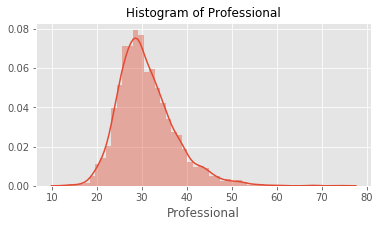

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


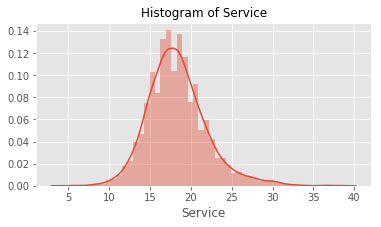

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


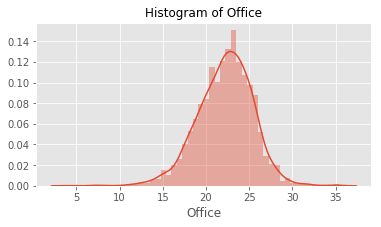

In [23]:
import seaborn as sns

for a in ['Professional', 'Service', 'Office']:
    ax=plt.subplots(figsize=(6,3))
    ax=sns.distplot(counties[a])
    title="Histogram of " + a
    ax.set_title(title, fontsize=12)
    plt.show()

Por ejemplo, a partir de las cifras anteriores puede observar la distribución de los condados que tienen un porcentaje de trabajadores en ocupaciones de profesionales, servicios u oficinas. Ver los histogramas puede indicar visualmente las características de estas features, como la media o la desviación.

La distribución de trabajadores profesionales, por ejemplo, revela que el condado típico tiene alrededor de 25-30% de trabajadores profesionales, con un sesgo correcto, una cola larga y un trabajador profesional que alcanza el 80% en algunos condados.

###  Feature engineering

Escala de datos: necesitamos estandarizar la escala de las columnas numéricas para poder utilizar cualquier método analítico basado en la distancia, de modo que podamos comparar las distancias relativas entre las diferentes columnas de características. Podemos usar minmaxscaler para transformar las columnas numéricas para que también se encuentren entre 0 y 1.

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
counties_scaler = pd.DataFrame(scaler.fit_transform(counties))
counties_scaler.columns = counties.columns
counties_scaler.index = counties.index


In [25]:
counties_scaler.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
counties_scaler.sample(3)

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Louisiana-Acadia,0.006166,0.006044,0.006285,0.021021,0.778557,0.202561,0.002172,0.004808,0.018018,0.007386,...,0.033708,0.063939,0.053763,0.585678,0.005275,0.899660,0.079470,0.191257,0.000000,0.276712
Missouri-Andrew,0.001700,0.001709,0.001691,0.021021,0.953908,0.009313,0.005429,0.004808,0.000000,0.002170,...,0.016854,0.012788,0.104839,0.455243,0.001816,0.816327,0.173841,0.166667,0.000000,0.136986
Iowa-Pottawattamie,0.009259,0.009264,0.009255,0.071071,0.891784,0.015134,0.003257,0.014423,0.000000,0.011424,...,0.023876,0.030691,0.080645,0.401535,0.009983,0.903061,0.105960,0.136612,0.020408,0.136986


## paso 3: modelado de datos

### Dimensionality reduction

Utilizaremos el análisis de componentes principales (PCA) para reducir la dimensionalidad de nuestros datos. Este método descompone la matriz de datos en características que son ortogonales entre sí. Las características ortogonales resultantes son combinaciones lineales del conjunto de características original. Puede pensar que este método toma muchas características y combina características similares o redundantes para formar un conjunto de características nuevo y más pequeño.

Podemos reducir la dimensionalidad con el algoritmo incorporado de Amazon SageMaker para PCA.
La documentación sobre el modelo de PCA se puede encontrar aquí: http://sagemaker.readthedocs.io/en/latest/pca.html

In [27]:
# importamos el modelo pca
from sagemaker import PCA

# creamos una instancia
bucket_name = 'sagemaker-us-west-2-859261764539'

# especificamos los parametros del modelo
num_components = 33

In [28]:
pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path='s3://'+ bucket_name +'/counties/',
             num_components=num_components)

A continuación, preparamos datos para Amazon SageMaker extrayendo la matriz numpy del DataFrame y convirtiendo explícitamente a float32

In [29]:
train_data = counties_scaler.values.astype('float32')
print(train_data)

[[0.00547453 0.00538076 0.00556558 ... 0.15027322 0.         0.20821919]
 [0.0194114  0.01924648 0.01957154 ... 0.15846995 0.04081633 0.20547946]
 [0.00265637 0.00290402 0.00241591 ... 0.19945355 0.01020408 0.48219177]
 ...
 [0.00243253 0.00241648 0.00244811 ... 0.3579235  0.02040816 0.70958906]
 [0.00358752 0.0035412  0.0036325  ... 0.19945355 0.         0.6657534 ]
 [0.00390581 0.0038241  0.00398515 ... 0.12021858 0.         0.74246573]]


La función ```record_set``` en el modelo de Amazon SageMaker PCA convierte una matriz numpy en un formato de conjunto de registros que es el formato requerido para que los datos de entrada sean entrenados. Este es un requisito para todos los modelos incorporados de Amazon SageMaker. El uso de este tipo de datos es una de las razones que permite que la capacitación de modelos dentro de Amazon SageMaker se realice con mayor rapidez, para conjuntos de datos más grandes en comparación con otras implementaciones de los mismos modelos, como la implementación de sklearn.


In [30]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

INFO:sagemaker:Creating training-job with name: pca-2019-04-04-03-02-00-642


2019-04-04 03:02:00 Starting - Starting the training job...
2019-04-04 03:02:05 Starting - Launching requested ML instances......
2019-04-04 03:03:12 Starting - Preparing the instances for training......
2019-04-04 03:04:28 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[04/04/2019 03:04:40 INFO 140644343416640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/04/2019 03:04:40 INFO 140644343416640] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components': u'33'}
[04/04/2019 03:04:40 INFO 140644343416640] Final configuration: {u'num_components': u'33', u'_num_gpus


2019-04-04 03:04:50 Training - Training image download completed. Training in progress.
2019-04-04 03:04:50 Uploading - Uploading generated training model
2019-04-04 03:04:50 Completed - Training job completed
Billable seconds: 22
CPU times: user 517 ms, sys: 9.45 ms, total: 526 ms
Wall time: 3min 12s


In [31]:
# INFO:sagemaker:Creating training-job with name: pca-2019-04-04-03-02-00-642

# Una vez creado el modelo, también podemos acceder a los parámetros del modelo subyacente.

job_name='pca-2019-04-04-03-02-00-642'
model_key = "counties/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [32]:
# despues de descomprimir el modelo, podemos cargar la matriz ND utilizando MXNet

pca_model_params = mx.ndarray.load('model_algo-1')

Tres grupos de parámetros del modelo están contenidos dentro del modelo PCA.

- mean: es opcional y solo está disponible si el hiperparámetro “subtract_mean” es verdadero cuando se llama al paso de entrenamiento desde la función original de PCA SageMaker

- v: contiene los componentes principales (igual que 'components_' en el modelo de PCA de sklearn)

- s: los valores singulares de los componentes para la transformación PCA. Esto no da exactamente el% de varianza del espacio de la característica original, pero puede dar el% de varianza del espacio de la característica proyectada

`explained-variance-ratio ~= square(s) / sum(square(s))`


In [33]:
s = pd.DataFrame(pca_model_params['s'].asnumpy())
v = pd.DataFrame(pca_model_params['v'].asnumpy())

Ahora podemos calcular la varianza explicada por los n componentes más grandes que queremos mantener. Para este ejemplo, tomemos los 5 componentes principales.

Podemos ver que los 5 componentes más grandes explican ~ 72% de la varianza total en nuestro conjunto de datos:

In [35]:
s.iloc[28:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.717983
dtype: float32

In [36]:
# tomamo los cinco componentes más grandes de nuestra matriz
s_5 = s.iloc[28:,:]
v_5 = v.iloc[:,28:]
v_5.columns = [0,1,2,3,4]

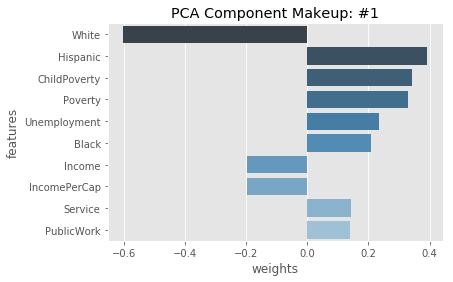

In [37]:
component_num=1

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaler.columns)), columns=['weights', 'features'])
comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

**_Explicación grafica anterior_**


Podemos examinar la composición de cada componente de PCA en función de las ponderaciones de las características originales que se incluyen en el componente. Por ejemplo, el siguiente código muestra el primer componente. Podemos ver que este componente describe un atributo de un condado que tiene una alta pobreza y desempleo, bajos ingresos e ingresos per cápita, y una alta población hispana / negra y una baja población blanca.

Tenga en cuenta que este es v_5 [4] o el último componente de la lista de componentes en v_5, pero en realidad es el componente más grande porque los componentes están ordenados de menor a mayor. Entonces v_5 [0] sería el componente más pequeño. De manera similar, cambie el valor de component_num para pasar por la composición de cada componente.

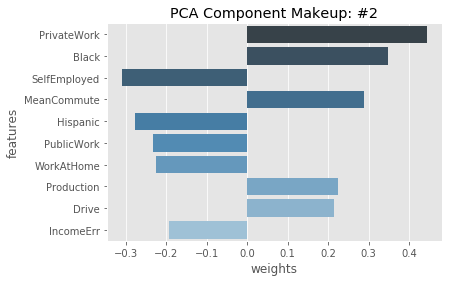

In [38]:
component_num=2

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaler.columns)), columns=['weights', 'features'])
comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

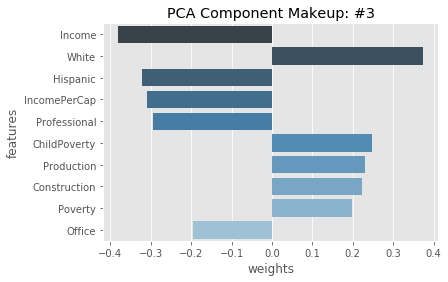

In [39]:
component_num=3

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaler.columns)), columns=['weights', 'features'])
comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

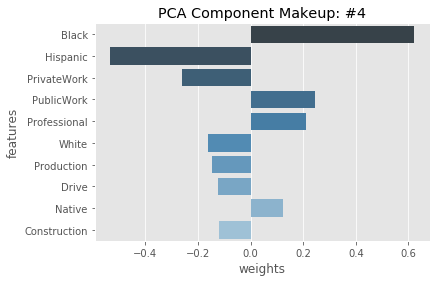

In [40]:
component_num=4

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaler.columns)), columns=['weights', 'features'])
comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

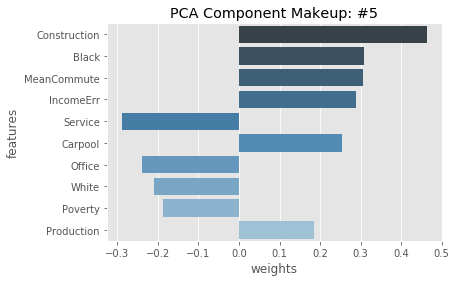

In [41]:
component_num=5

first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, counties_scaler.columns)), columns=['weights', 'features'])
comps['abs_weights'] = comps['weights'].apply(lambda x: np.abs(x))
ax = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [42]:
# vamos analizar la composición de cada uno de los componentes de la PCA
# ytratar de comprender cuáles son los atributos clave positivos y negativos

PCA_list=['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5']

#PCA_list=["Poverty/Unemployment", "Self Employment/Public Workers", "High Income/Professional & Office Workers", 
#          "Black/Native Am Populations & Public/Professional Workers", "Construction & Commuters"]

### Desplegando el modelo de PCA

Ahora podemos implementar este modelo de punto final y usarlo para hacer predicciones. Este modelo ahora está activo y alojado en un tipo de instancia que especificamos.

Nota: También podemos pasar nuestro conjunto de datos original al modelo para que podamos transformar los datos utilizando el modelo que creamos. Luego podemos tomar los 5 componentes más grandes y esto reducirá la dimensionalidad de nuestros datos de 34 a 5.

In [43]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: pca-2019-04-04-03-06-44-011
INFO:sagemaker:Creating endpoint with name pca-2019-04-04-03-02-00-642


---------------------------------------------------------------------------!CPU times: user 420 ms, sys: 37.3 ms, total: 457 ms
Wall time: 6min 20s


In [4]:
!git push origin master

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 111.53 KiB | 11.15 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0)
To https://github.com/iris9112/amazon_sagemaker_test.git
 * [new branch]      master -> master


In [45]:
%%time
result = pca_predictor.predict(train_data)
counties_transformed = pd.DataFrame()

for a in result:
    b=a.label['projection'].float32_tensor.values
    counties_transformed = counties_transformed.append([list(b)])
    
counties_transformed.index = counties_scaler.index
counties_transformed = counties_transformed.iloc[:,28:]
counties_transformed.columns = PCA_list

CPU times: user 6.73 s, sys: 0 ns, total: 6.73 s
Wall time: 7.01 s


Ahora hemos creado un conjunto de datos donde cada condado se describe mediante los 5 componentes principales que analizamos anteriormente. Cada uno de estos 5 componentes es una combinación lineal del espacio de la característica original. Podemos interpretar cada uno de estos 5 componentes analizando la composición del componente mostrado anteriormente.

In [48]:
counties_transformed.sample(10)

,comp_1,comp_2,comp_3,comp_4,comp_5
Iowa-Winneshiek,-0.092328,-0.000731,-0.073703,-0.106640,-0.409747
Indiana-Jackson,-0.032890,-0.198377,0.029130,0.238194,-0.200640
Tennessee-Haywood,0.181861,0.285309,0.089897,0.326873,0.370624
Wisconsin-Monroe,-0.117793,-0.044613,0.097454,0.019710,-0.160427
New York-Richmond,0.064001,0.118579,-0.532747,0.064026,0.010611
Michigan-Ionia,0.014421,-0.114102,0.060207,0.151785,-0.125802
Nebraska-Wheeler,0.110136,0.133115,0.179281,-0.568277,-0.458711
Arkansas-Boone,-0.177966,-0.101143,0.095099,0.096205,-0.157381
Virginia-Buchanan,-0.037836,-0.170180,0.284362,0.241846,0.029305
Illinois-White,0.049834,-0.120358,0.134320,0.064329,-0.246677


### Segmentación de la población utilizando agrupamiento no supervisado

Ahora, usaremos el algoritmo Kmeans para segmentar la población de condados por los 5 atributos de PCA que hemos creado. Kmeans es un algoritmo de agrupación en clústeres que identifica grupos de condados similares según sus atributos. Ya que tenemos ~ 3000 condados y 34 atributos en nuestro conjunto de datos original, el gran espacio de características puede haber dificultado la agrupación de los condados de manera efectiva. En cambio, hemos reducido el espacio de funciones a 5 componentes de PCA y nos agruparemos en este conjunto de datos transformado.

Modelo KMeans: El algoritmo Kmeans permite al usuario especificar cuántos clusters identificar. En este caso, intentemos encontrar los 7 grupos principales de nuestro conjunto de datos.

In [50]:
train_data = counties_transformed.values.astype('float32')

In [51]:
from sagemaker import KMeans

num_clusters = 7

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/counties/',              
                k=num_clusters)

In [52]:
%%time
# entrenamos el modelo

kmeans.fit(kmeans.record_set(train_data))

INFO:sagemaker:Creating training-job with name: kmeans-2019-04-04-03-22-15-342


2019-04-04 03:22:15 Starting - Starting the training job...
2019-04-04 03:22:17 Starting - Launching requested ML instances......
2019-04-04 03:23:28 Starting - Preparing the instances for training.........
2019-04-04 03:25:12 Downloading - Downloading input data
2019-04-04 03:25:12 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[04/04/2019 03:25:14 INFO 140561856112448] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]


2019-04-04 03:25:24 Uploading - Uploading generated training model
2019-04-04 03:25:24 Completed - Training job completed
Billable seconds: 22
CPU times: user 534 ms, sys: 30.5 ms, total: 565 ms
Wall time: 3min 42s


Ahora implementamos el modelo y podemos pasar el conjunto de entrenamiento original para obtener las etiquetas para cada entrada. Esto nos dará a qué grupo pertenece cada condado.

# Nota:

No pude completar esta parte del ejercicio por la limitación de amazon de `ResourceLimitExceeded`

In [ ]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

In [ ]:
%%time
result=kmeans_predictor.predict(train_data)

In [ ]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

In [ ]:
ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

En este punto deberias poder ver la distribución de cluster
![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/29/census-sagemaker-3.gif)


## Paso 4: Sacar conclusiones de nuestro modelado

Explicar el resultado del modelado es un paso importante para hacer uso de nuestro análisis. Al combinar PCA y Kmeans, y la información contenida en los atributos del modelo dentro de un modelo capacitado de Amazon SageMaker, podemos formar conclusiones concretas basadas en los datos.

### Accediendo a los atributos del modelo KMeans.

Primero, iremos al cubo donde se almacena el modelo kmeans y lo extraeremos.

In [65]:
job_name='kmeans-2019-04-04-03-22-15-342'
model_key = "counties/" + job_name + "/output/model.tar.gz"

In [66]:
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [67]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [69]:
# location of the centers of each cluster identified by the Kmeans algorithm
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = counties_transformed.columns
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,0.109130,-0.174594,-0.090097,-0.200411,0.327722
1,-0.020972,-0.066578,-0.019553,0.044579,-0.257245
2,-0.029638,-0.051157,0.125632,0.105193,-0.020188
3,0.007703,0.104717,0.086667,-0.370532,-0.129515
4,-0.078752,-0.419361,-0.203775,-0.214864,1.235091
5,0.100010,0.275388,0.112571,0.236753,0.414249
6,-0.018100,0.110387,-0.362745,0.067745,-0.088986


Podemos trazar un mapa de calor de los centroides y su ubicación en el espacio de los feature transformados. Esto nos da una idea de qué características definen cada grupo. A menudo, con el aprendizaje no supervisado, los resultados son difíciles de interpretar. Esta es una manera de utilizar los resultados de las técnicas de agrupación de PCA como un plus. Como pudimos examinar la composición de cada componente de PCA, podemos entender lo que representa cada centroide en términos de los componentesque hemos interpretado anteriormente.

Por ejemplo, podemos ver que el grupo 1 tiene el valor más alto en el atributo "Construcción y Viajeros" mientras que tiene el valor más bajo en el atributo "Trabajo por cuenta propia / Trabajadores públicos" en comparación con otros grupos. De manera similar, el grupo 4 tiene valores altos en "Construcción y viajeros", "Trabajadores de alto ingreso / profesionales y de oficina" y "Trabajadores por cuenta propia / Trabajadores públicos".

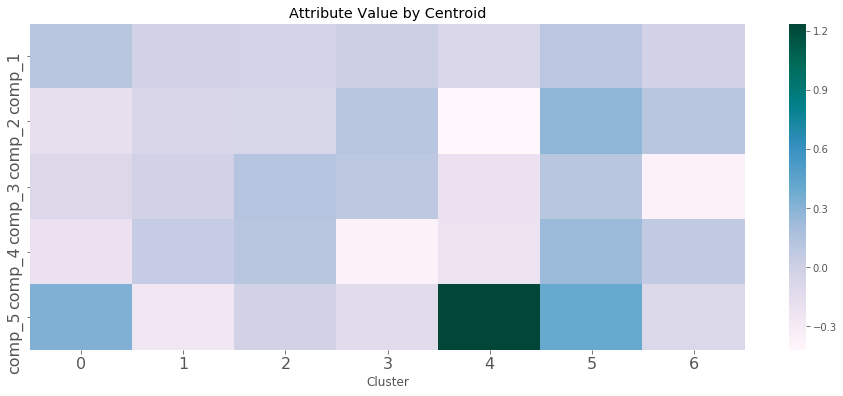

In [75]:
plt.figure(figsize = (16, 6))

ax = sns.heatmap(cluster_centroids.T, cmap = 'PuBuGn')

ax.set_xlabel("Cluster")

plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)

ax.set_title("Attribute Value by Centroid")

plt.show()

### Conclusión

Acaba de recorrer un flujo de trabajo de ciencia de datos para el aprendizaje no supervisado, específicamente agrupando un conjunto de datos utilizando KMeans después de reducir la dimensionalidad utilizando PCA. Al acceder a los modelos subyacentes creados dentro de Amazon SageMaker, pudimos mejorar la capacidad de explicación de nuestro modelo y sacar conclusiones viables. Usando estas técnicas, hemos podido entender mejor las características esenciales de los diferentes condados en los EE. UU. Y segmentar el electorado en grupos según corresponda.

In [ ]:
# eliminar endpoints, asi si estuviera pagando evitaria cargos adicionales en la factura de AWS
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

In [79]:
!git add .

In [80]:
!git commit -m 'mapa de calor y conclusion'

[master 155e711] mapa de calor y conclusion
 Committer: EC2 Default User <ec2-user@ip-172-16-90-32.us-west-2.compute.internal>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 5 files changed, 968 insertions(+), 27 deletions(-)
 rewrite model.tar.gz (100%)
 rewrite model_algo-1 (100%)
 create mode 100644 state_33e1c3d0-e4d0-4b79-877f-a1d7e62c0780


In [81]:
!git push origin master

Counting objects: 8, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 24.47 KiB | 4.08 MiB/s, done.
Total 8 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 1 local object.
To https://github.com/iris9112/amazon_sagemaker_test.git
   ba6e088..155e711  master -> master
